# Load and plot results from eval script runs

In [7]:
import matplotlib.pyplot as plt
import pickle
import numpy as np

from pprint import pprint

In [22]:
res_file_path = (
    "/Users/szepi1991/Code/adaptive_time/code/adaptive_time/tradeoff_results_20240227-232625.pkl"
)

base_policy_returns = [49871.42448544637, 30.134219177716098]

with open(res_file_path, "rb") as f:
    loaded = pickle.load(f)
    if "results" in loaded:
        results = loaded["results"]
        print("The config for these results was: ")
        pprint(loaded["config"])
        policy_prob = loaded["config"]["policy_to_evaluate"][2]
    else:
        results = loaded
        policy_prob = None
        print("Could not find a config.")

if policy_prob:
    expected_return = np.dot(base_policy_returns, [policy_prob, 1.0 - policy_prob])
    print()
    print("expected_return:", expected_return)

The config for these results was: 
{'budget': 20000,
 'budget_type': <BudgetType.UPDATES: 2>,
 'epsilon': 0.0,
 'gamma': 0.99999,
 'max_env_steps': None,
 'num_runs': 2,
 'policy_to_evaluate': ('/Users/szepi1991/Code/adaptive_time/policy_to_eval_good.npy',
                        '/Users/szepi1991/Code/adaptive_time/policy_to_eval_bad.npy',
                        0.5),
 'save_limit': None,
 'seed': 13,
 'tau': 0.02,
 'termination_prob': 0,
 'weights_to_evaluate': None}
expected_return: 24950.77935231204


In [9]:
results.keys()

dict_keys(['q0_10', 'q0_5', 'q0_1', 'u5', 'u10', 'u20'])

In [10]:
print("number of runs:", len(results['q0_10']))

number of runs: 2


In [11]:
print("recorded stats:")
pprint(list(results['q0_10'][0].keys()))

recorded stats:
['total_return',
 'total_pivots',
 'total_interactions',
 'num_episode',
 'returns_per_episode_q',
 'predicted_returns_q',
 'returns_per_episode_v',
 'predicted_returns_v']


The following is only true if we used an interaction budget. If we
used an update budget, we can run some methods longer.

Let's do a minor sanity check. Since we used no randomness (?), ALL
runs should have the same number of episodes, and each corresponding
episode should have the same number of interactions.

In [26]:
print("Numbers of episodes:")
max_episodes = 0
for name, runs_data in results.items():
    num_episodes = [len(run["returns_per_episode_v"]) for run in runs_data]
    max_episodes = max(max_episodes, max(num_episodes))
    print(f" * {name}: {num_episodes}")

Numbers of episodes:
 * q0_10: [810, 848]
 * q0_5: [511, 526]
 * q0_1: [25, 16]
 * u5: [13, 10]
 * u10: [35, 22]
 * u20: [53, 47]


In [13]:
def plot_stuff(tuples_of_x_y_labels_kwargs, title, ylabel, show):

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    for x, y, label, kwargs in tuples_of_x_y_labels_kwargs:
        plt.plot(x, y, label=label, **kwargs)

    plt.ylabel(ylabel, rotation=0, labelpad=40)
    plt.legend()

    if title is not None:
      plt.title(title)

    if show:
      plt.show()
    return ax


In [14]:
pprint(list(results["q0_10"][0].keys()))

['total_return',
 'total_pivots',
 'total_interactions',
 'num_episode',
 'returns_per_episode_q',
 'predicted_returns_q',
 'returns_per_episode_v',
 'predicted_returns_v']


In [15]:
pprint(np.stack(results["q0_10"][0]["predicted_returns_v"]))

array([13811.59823828, 13811.59823828, 13811.66233154, 13811.68517765,
       13811.68517765, 13811.69745112, 13811.70539072, 13811.70539072,
       13811.70539072, 13811.70539072, 13811.70539072, 13811.71110852,
       13811.71552369, 13811.71552369, 13811.71552369, 13811.71552369,
       13811.71552369, 13811.71910282, 13811.71910282, 13811.71910282,
       13811.71910282, 13811.72210903, 13811.72210903, 13811.72210903,
       13811.72470255, 13811.72470255, 13811.72698686, 13811.72698686,
       13811.72903198, 13811.72903198, 13811.72903198, 13811.72903198,
       13811.72903198, 13811.73088709, 13811.73258789, 13811.73416095,
       13811.73416095, 13811.73562653, 13811.73700036, 13811.7382949 ,
       13811.73952015, 13811.74068427, 13811.74179398, 13811.74285489,
       13811.74285489, 13811.74285489, 13811.74387172, 13811.74484848,
       13811.74484848, 13811.74578863, 13811.74578863, 13811.74669515,
       13811.74757063, 13811.74841734, 13811.74923729, 13811.75003226,
      

In [16]:
# def pad_along_axis(
#         array: np.ndarray, target_length: int, axis: int = 0, pad_value=0.0
# ) -> np.ndarray:

#     pad_size = target_length - array.shape[axis]

#     if pad_size <= 0:
#         return array

#     npad = [(0, 0)] * array.ndim
#     npad[axis] = (0, pad_size)

#     return np.pad(
#         array, pad_width=npad, mode='constant', constant_values=pad_value)


def pad_combine(list_of_vecs, pad_value=np.nan):
    # print("original shapes")
    # for p in list_of_vecs:
    #     print(p.shape)

    max_len = max([len(v) for v in list_of_vecs])
    padded = [
        np.pad(v, (0, max_len - len(v)), mode='constant', constant_values=pad_value)
        # pad_along_axis(v, max_len, axis=0, pad_value=pad_value)
        for v in list_of_vecs
    ]
    # print("padded shapes")
    # for p in padded:
    #     print(p.shape)
    # print("---")
    return np.stack(padded, axis=1)

In [17]:
preds_per_method = {}   # nethod -> [traj_len, n_runs] of pred Vs
rets_per_method = {}     # nethod -> [traj_len, n_runs] of est Vs
for name in results.keys():
    # print("=== processing ", name)
    preds_per_method[name] = pad_combine([
        np.array(run["predicted_returns_v"])
        for run in results[name]
    ])
    rets_per_method[name] = pad_combine([
        np.array(run["returns_per_episode_v"])
        for run in results[name]
    ])

# At this point, we combined all runs of each method into
# a single array of shape [traj_len, n_runs]


## Plots of Average Behaviour

In [18]:
# results = results[0]


# plot_est_vs_pred([
#    (average_returns, 'Empirical Returns', {}),
#    (predicted_returns, 'Predicted Returns', {})],
#    title='Empirical vs Predicted Returns')


## Plots of individual runs

### Plot of sample returns -- by episodes

Since we are doing evaluation and there is no randomness at this point,
these should be the same accross all runs and all methods!

In [19]:
for row in rets_per_method["q0_10"].T:
    print(row.shape)

(848,)
(848,)


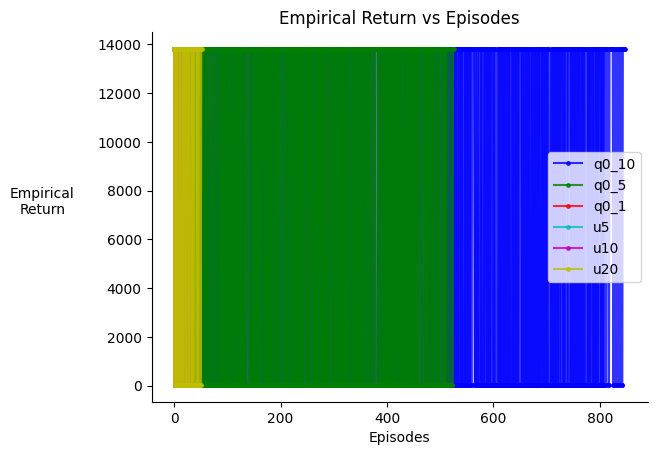

In [20]:

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

tuples_of_y_labels_kwargs = []
for i, (name, array_of_runs) in enumerate(rets_per_method.items()):
    for r_idx, est_rets in enumerate(array_of_runs.T):
        tuples_of_y_labels_kwargs.append((
            list(range(len(est_rets))),
            est_rets,
            name if r_idx==0 else None,
            # {"color": colors[i], "marker": ".", "linestyle": "None", "markersize": 5, "alpha": 0.8}
            {"color": colors[i], "marker": ".", "linestyle": "-",
             "markersize": 5, "alpha": 0.8}
        ))

ax = plot_stuff(
    tuples_of_y_labels_kwargs, "Empirical Return vs Episodes",
    "Empirical\nReturn" ,False)
# ax.set_yscale('log')
ax.set_xlabel('Episodes')
plt.show()



It is kind of surprising at first that some go longer than others. It's because we ran with an update budget and some methods make fewer updates per episode.

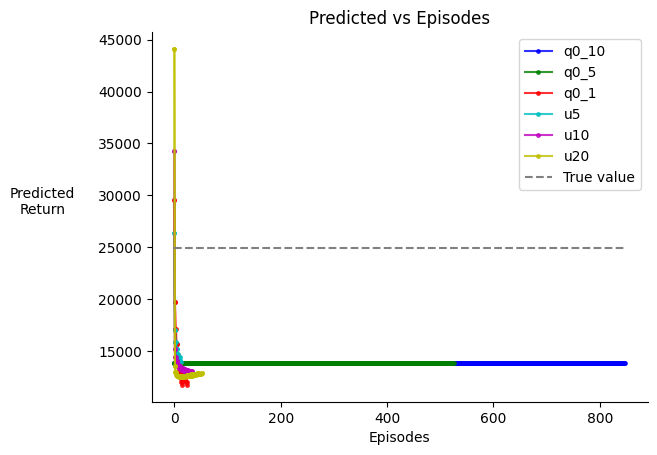

In [27]:
# Against episodes.

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

tuples_of_y_labels_kwargs = []
for i, (name, array_of_runs) in enumerate(preds_per_method.items()):
    for r_idx, pred_rets in enumerate(array_of_runs.T):
        tuples_of_y_labels_kwargs.append((
            list(range(len(pred_rets))),
            pred_rets,
            name if r_idx==0 else None,
            # {"color": colors[i], "marker": ".", "linestyle": "None", "markersize": 5, "alpha": 0.8}
            {"color": colors[i], "marker": ".", "linestyle": "-",
             "markersize": 5, "alpha": 0.8}
        ))

ax = plot_stuff(
    tuples_of_y_labels_kwargs, "Predicted vs Episodes",
    "Predicted\nReturn" ,False)

plt.hlines(
    expected_return, 0, max_episodes,
    colors='grey', linestyles='dashed',
    label='True value')
ax.legend()
# ax.set_yscale('log')
ax.set_xlabel('Episodes')
plt.show()



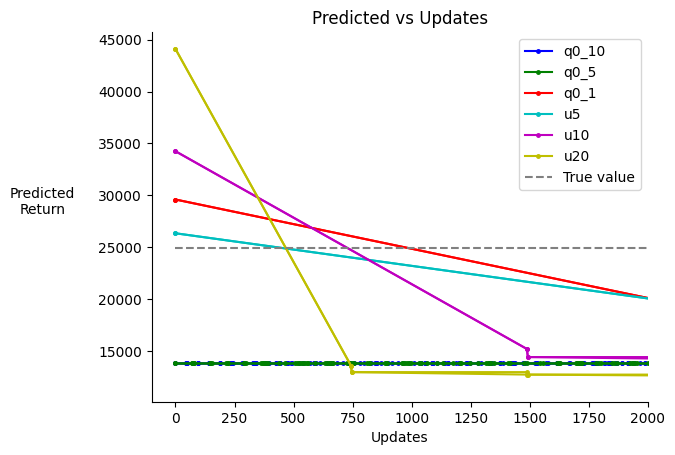

In [35]:
# Against updates.

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

tuples_of_x_y_labels_kwargs = []
for i, (name, array_of_runs) in enumerate(results.items()):
    for r_idx, data_for_run in enumerate(array_of_runs):
        tuples_of_x_y_labels_kwargs.append((
            data_for_run["total_pivots"][:-1],
            data_for_run["predicted_returns_v"],
            name if r_idx==0 else None,
            # {"color": colors[i], "marker": ".", "linestyle": "None", "markersize": 5, "alpha": 0.8}
            {"color": colors[i], "marker": ".", "linestyle": "-",
             "markersize": 5, "alpha": 1.0}
        ))

ax = plot_stuff(
    tuples_of_x_y_labels_kwargs, "Predicted vs Updates",
    "Predicted\nReturn" ,False)

min_x, max_x = ax.get_xlim()
plt.hlines(
    expected_return, 0, max_x,
    colors='grey', linestyles='dashed',
    label='True value')
ax.legend()
ax.set_xlim(-100, 2000)
# ax.set_yscale('log')
ax.set_xlabel('Updates')
plt.show()

